NOTE:  Need data with Max/Impressions; Need separator between phrases in Primary_kw and Tags.


# BuzzModel - Build a prediction model for articles
### Step 1: Load Data and Clean it up
#### A. Features: Clean Null
#### B. Target: Normalize - use (freq, Impressions) and max_impressions
Use Viral, Non-Viral (Pick -1 Std. Dev. as an arbitrary marker)
Try Multiple Classes: 1 Buzz (Bottom quartile), 2 (Middle 50%) Buzz and 3(Top Quartile) Buzz
### Step 2: Describe data and understand data
#### A. ...
### Step 3: Select Features to try-out
#### A. Combination of All Texts
#### B. Identify ones with signals
#### C. Remove infrequent terms
#### D. Remove too-frequent terms
#### E. Remove instances with time bias (News)
#### F.  Use tags and primary_kw phrases as tokens instead of breaking them apart (Convert String to List)
#### G. 
### Step 4: Modeling
#### Model Selection:  Multinomial NB, Logistic Regression, SVM (Maybe if we have time.
#### Hyperparameter tuning
### Step 5: Pipeline
#### Cross Validation
### Step 6: Feature Engineering and Reduction 
#### Try another model:  Length of title, Number of Tags, List or other description of the title
#### Feature reduction (PCA, SVD)
#### Feature union
#### Weighted feature analysis - what is more important:  Title, Descr, Keywords, Tags
### Step 7: Random things to try:
#### A. Based upon articles that go viral in a country, impact of : source country, cats, keywords, etc. (pandas can do this)

In [274]:
import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [275]:
df = pd.DataFrame()
df = pd.read_csv('may_june_july.csv', delimiter="|")
#ab = xy[:10]
#df = ab.copy()
#df = df[df.metav != 'news']
df = df.reset_index(drop=True)
#df.tail()



9.97900229397
3.21629982395


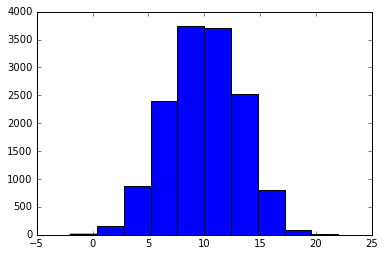

In [276]:
# Combine all text
df['AllText'] = ""
df['primary_kw'].fillna(" ", inplace=True)
df['tags'].fillna(" ", inplace=True)
for i, row in df.iterrows():
    #cv = df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,8]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    #Remove metav and cat
    cv = df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    df.set_value(i,'AllText',cv)

# Log to convert to Normal Distribution
df['Log'] = df['freq']*df['impressions']/1000
for i, row in df.iterrows():
    cv = math.log(df.iloc[i,12],2)
    df.set_value(i,'Log',cv)
    
# analyse data a bit
data_mean = df["Log"].mean()
print data_mean
data_std = df["Log"].std()
print data_std
%matplotlib inline
plt.hist(df["Log"])
plt.show()

# Virality defined as -1 sigma from mean
df['viral'] = np.where(df['Log']<data_mean-data_std, 'notviral', 'viral')
df['viral_num'] = df.viral.map({'notviral':0, 'viral':1})

In [277]:
X = df.AllText
y = df.viral_num
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10722,)
(3575,)
(10722,)
(3575,)


In [278]:
# instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_df=0.1)

# learn training data vocabulary, then use it to create a document-term matrix
# FOLLOWING CAN BE DONE IN SINGLE STEP:  X_train_dtm = vect.fit_transform(X_train)
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3575x15784 sparse matrix of type '<type 'numpy.int64'>'
	with 73083 stored elements in Compressed Sparse Row format>

In [279]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 10.6 ms, sys: 3 ms, total: 13.6 ms
Wall time: 11.7 ms


In [280]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.81202797202797206

In [281]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 219,  404],
       [ 268, 2684]])

In [282]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.59620724,  0.99940101,  0.99998769, ...,  0.99999892,
        0.9999999 ,  0.99711796])

In [283]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.73463864855341976

In [284]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [285]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 396 ms, sys: 8.45 ms, total: 404 ms
Wall time: 408 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [286]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [287]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.78232517,  0.9434724 ,  0.97739927, ...,  0.98232756,
        0.99345644,  0.82977384])

In [288]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.82321678321678327

In [289]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.72601946826049324

In [290]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

15784

In [291]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  0.,   7.,   4., ...,   1.,   0.,   1.],
       [  4.,  40.,   4., ...,   2.,   3.,   1.]])

In [292]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 15784)

In [293]:
# number of times each token appears across all Non-viral Buzzes
non_viral_token_count = nb.feature_count_[0, :]
non_viral_token_count

array([ 0.,  7.,  4., ...,  1.,  0.,  1.])

In [294]:
# number of times each token appears across all Viral Buzzes
viral_token_count = nb.feature_count_[1, :]
viral_token_count

array([  4.,  40.,   4., ...,   2.,   3.,   1.])

In [295]:
# create a DataFrame of tokens with their separate non-viral and viral counts
tokens = pd.DataFrame({'token':X_train_tokens, 'non_viral':non_viral_token_count, 'viral':viral_token_count}).set_index('token')
#tokens.head()

In [296]:
# examine 5 random DataFrame rows
#tokens.sample(20, random_state=6)

In [297]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([ 1812.,  8910.])

In [298]:
# add 1 to non-viral and viral counts to avoid dividing by 0
tokens['non_viral'] = tokens.non_viral + 1
tokens['viral'] = tokens.viral + 1
#tokens.sample(5, random_state=6)

In [ ]:
# convert the non-viral and viral counts into frequencies
tokens['non_viral'] = tokens.non_viral / nb.class_count_[0]
tokens['viral'] = tokens.viral / nb.class_count_[1]
#tokens.sample(5, random_state=6)

In [ ]:
# calculate the ratio of viral-to-non-viral for each token
tokens['viral_ratio'] = tokens.viral / tokens.non_viral
#tokens.sample(5, random_state=6)

In [ ]:
# examine the DataFrame sorted by viral_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
#tokens.sort_values('viral_ratio', ascending=False)

In [ ]:
# look up the viral_ratio for a given token
tokens.loc['stanford', 'viral_ratio']